In [4]:
#####Random-effect logistic regression with Laplace approximation#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
import seaborn as sns

#np.random.seed(98537)

In [5]:
####データの発生####
##データとIDの設定
#データの設定
hh = 10000
pt = np.random.poisson(np.random.gamma(10, 1/0.225), hh)
hhpt = np.sum(pt)
no = np.arange(hh)

In [6]:
#IDの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
d_dt = sparse.coo_matrix((np.repeat(1, hhpt), (d_id, range(hhpt))), shape=(hh, hhpt)).tocsr()    

In [7]:
#素性ベクトルを生成
k1 = 5; k2 = 6; k3 = 6
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)   #すべての説明変数を結合
k = x.shape[1]

In [8]:
##応答変数を生成
rp = 0
while True:
    rp = rp + 1
    print(rp)

    #モデルパラメータを生成
    alpha = np.array([0])
    tau = np.array([0.5])
    theta = np.random.normal(alpha, tau, hh)
    beta = np.append(-1.0, np.random.normal(0, 0.7, k-1))
    alphat = alpha.copy(); taut = tau.copy(); thetat = theta.copy(); betat = beta.copy()

    #ロジスティックモデルから生成
    logit = np.dot(x, beta) + theta[d_id] 
    Prob = np.exp(logit) / (1 + np.exp(logit))
    y = np.random.binomial(1, Prob, hhpt)
    y_vec = y[:, np.newaxis]
    
    #応答変数のbreak条件
    if np.mean(y) > 0.15 and np.mean(y) < 0.4:
        break

1
2
3
4
5
6
7
8
9


0.28903601397544365
133852


(array([20097., 52918., 58282., 54409., 47829., 41672., 35707., 30479.,
        26102., 21636., 18138., 15127., 12124.,  9808.,  7440.,  5303.,
         3369.,  1878.,   692.,    88.]),
 array([0.00542745, 0.05402648, 0.1026255 , 0.15122453, 0.19982355,
        0.24842257, 0.2970216 , 0.34562062, 0.39421964, 0.44281867,
        0.49141769, 0.54001672, 0.58861574, 0.63721476, 0.68581379,
        0.73441281, 0.78301183, 0.83161086, 0.88020988, 0.92880891,
        0.97740793]),
 <a list of 20 Patch objects>)

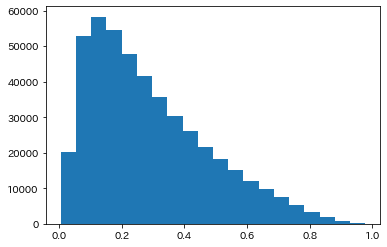

In [9]:
#データの確認
print(np.mean(y))
print(np.sum(y))
plt.hist(Prob, bins=20)

In [10]:
####ラプラス近似EMアルゴリズムによりパラメータを推定####
##変量効果をラプラス近似で推定するための関数
#変量効果の対数事後分布の和
def log_posterior(theta, beta, tau, y, x, d_id, d_dt):
    #対数尤度を計算
    logit_exp = np.exp(np.dot(x, beta) + theta[d_id, ])
    Prob = logit_exp / (1 + logit_exp)
    Loglike = y*np.log(Prob) + (1-y)*np.log(1-Prob)
    
    #対数事前分布を計算
    Prior = -0.5 * (np.power(theta, 2) / tau)
    
    #対数尤度の和
    Posterior = -(np.sum(Loglike) + np.sum(Prior))
    return Posterior

#対数事後分布の微分関数
def dlog_posterior(theta, beta, tau, y, x, d_id, d_dt):
    #応答確率を計算
    logit_exp = np.exp(np.dot(x, beta) + theta[d_id, ])
    Prob = logit_exp / (1 + logit_exp)

    #勾配ベクトルとその和を計算
    dlogit = y - Prob
    dnm = -theta / tau
    LLd = -(np.array(np.dot(d_dt, sparse.csr_matrix(dlogit).T).todense()).reshape(-1) + dnm)   #勾配の和
    return LLd

#対数事後分布のヘシアン
def hessian(theta, beta, tau, y, x, d_id, d_dt):
    #応答確率を計算
    logit_exp = np.exp(np.dot(x, beta) + theta[d_id, ])
    Prob = logit_exp / (1 + logit_exp)

    #対数尤度と対数事前分布の二階微分
    dlogit = -Prob * (1 - Prob)
    dnm = -(1 / tau)
    hessian = np.array(np.dot(d_dt, sparse.csr_matrix(dlogit).T).todense()).reshape(-1) + dnm   #ヘシアン
    return hessian

In [11]:
##回帰ベクトルを推定するための関数
#ロジスティック回帰モデルの対数尤度関数
def loglike(beta, theta_vec, tau, y, y_vec, x, d_id, d_dt):
    #応答確率を計算
    logit_exp = np.exp(np.dot(x, beta) + theta_vec)
    Prob = logit_exp / (1 + logit_exp)
    
    #対数尤度関数の和
    Loglike = y*np.log(Prob) + (1-y)*np.log(1-Prob)
    LL = -np.sum(Loglike)
    return LL

#対数事後分布の微分関数
def dloglike(beta, theta_vec, tau, y, y_vec, x, d_id, d_dt):
    #応答確率を計算
    logit_exp = np.exp(np.dot(x, beta) + theta_vec)
    Prob = logit_exp / (1 + logit_exp)

    #勾配ベクトルとその和を計算
    dlogit = y_vec*x - Prob[:, np.newaxis]*x
    LLd = -np.sum(dlogit, axis=0)
    return LLd

In [12]:
##初期値の設定
#変量効果の事前分布の初期値
alpha = np.array([0])
tau = np.array([1.0])
inv_tau = 1 / tau

#モデルパラメータの初期値
beta = np.append(-0.5, np.random.normal(0, 0.3, k-1))
theta = np.random.normal(0, 0.2, hh)
LL = -log_posterior(theta, beta, tau, y, x, d_id, d_dt)
print(LL)

-321011.5470578781


In [13]:
##アルゴリズムの設定
LL1 = -1000000000   #対数尤度の初期値
tol = 1.0
iter = 1
dl = 100
L = 500   #モンテカルロサンプリング数

In [14]:
##対数事後分布の基準値
#1パラメータモデルでの対数尤度
LLst = np.sum(y*np.log(np.mean(y)) + (1-y)*np.log(np.mean(1-y)))
print(LLst)

#真値での対数尤度
LLbest = -log_posterior(thetat, betat, taut, y, x, d_id, d_dt)
print(LLbest)

-278454.47684431943
-240074.65860903898


In [15]:
####EMアルゴリズムでパラメータを更新####
while dl > tol:   #dlがtol以上なら繰り返す
    ##ラプラス近似で変量効果のパラメータを更新
    #共役勾配法で変量効果をMAP推定
    res1 = optimize.minimize(log_posterior, theta, jac=dlog_posterior, method='CG', args=(beta, tau, y, x, d_id, d_dt),
                            options={"gtol": 0.01, "disp":False})

    #パラメータを更新
    theta = res1.x   #変量効果の事後期待値
    inv_H = 1 / -hessian(theta, beta, tau, y, x, d_id, d_dt)   #変量効果の事後分散
    LL = -res1.fun


    ##Mステップでパラメータを更新
    #準ニュートン法で回帰ベクトルを更新
    theta_vec = theta[d_id, ]
    res2 = optimize.minimize(loglike, beta, jac=dloglike, method='BFGS', args=(theta_vec, tau, y, y_vec, x, d_id, d_dt),
                            options={"gtol": 0.01, "disp":False})
    beta = res2.x

    #事前分散の更新
    tau = (np.sum(np.power(theta, 2)) + np.sum(inv_H)) / hh
    inv_tau = 1 / tau


    ##対数尤度の更新とアルゴリズムの収束判定
    #対数尤度を更新
    LL = -log_posterior(theta, beta, tau, y, x, d_id, d_dt)

    #アルゴリズムの収束判定
    iter = iter + 1
    dl = LL- LL1
    LL1 = LL
    print(np.round(np.array([LL, LLbest]), 1))

[-238228.7 -240074.7]
[-237160.  -240074.7]
[-237095.8 -240074.7]
[-237071.2 -240074.7]
[-237061.1 -240074.7]
[-237068.  -240074.7]


In [75]:
##推定結果を確認
#最大化された対数事後分布
print(np.round(np.array([-log_posterior(theta, beta, tau, y, x, d_id, d_dt), LLbest]), 1))
print(np.round(np.array([-loglike(beta, theta[d_id, ], tau, y, y_vec, x, d_id, d_dt),
                         -loglike(betat, thetat[d_id, ], taut, y, y_vec, x, d_id, d_dt)]), 1))

#推定されたパラメータ
print(np.round(np.array([np.sqrt(tau), taut]), 3))
print(np.round(np.append(beta, betat).reshape(2, k), 3))
pd.DataFrame(np.hstack((np.array(pt[:, np.newaxis], dtype="int"), theta[:, np.newaxis], thetat[:, np.newaxis])))

[-179164.7 -182259.2]
[-175633.2 -179788.2]
[0.67 0.5 ]
[[-0.713 -0.13   0.257  1.635 -0.838 -0.837  1.062 -0.976 -0.282 -0.114
  -0.875 -1.398  0.823  0.493  0.088  0.35   0.281]
 [-1.    -0.125  0.256  1.622 -0.818 -0.853  1.066 -0.989 -0.275 -0.13
  -0.859 -1.387  0.806  0.466  0.055  0.332  0.258]]


,0,1,2
0,40.0,0.088919,1.015369
1,40.0,-0.493967,0.062101
2,47.0,-0.093032,0.245490
3,42.0,-0.167141,-0.136964
4,38.0,-0.104980,-0.231083
5,41.0,0.751607,0.830517
6,26.0,-0.919096,-0.824070
7,37.0,-0.517479,0.140468
8,44.0,-0.178417,0.073438
9,43.0,-0.184343,0.175264


In [77]:
#推定された確率
logit_exp = np.exp(np.dot(x, beta) + theta[d_id, ])
Prob = logit_exp / (1 + logit_exp)
logit_exp = np.exp(np.dot(x, betat) + thetat[d_id, ])
Probt = logit_exp / (1 + logit_exp)
pd.DataFrame(np.hstack((d_id[:, np.newaxis], pt_id[:, np.newaxis], Prob[:, np.newaxis], Probt[:, np.newaxis])))

,0,1,2,3
0,0.0,0.0,0.504182,0.652399
1,0.0,1.0,0.154941,0.249547
2,0.0,2.0,0.650931,0.770943
3,0.0,3.0,0.088064,0.152550
4,0.0,4.0,0.460193,0.612557
5,0.0,5.0,0.054643,0.095132
6,0.0,6.0,0.595537,0.736082
7,0.0,7.0,0.334955,0.484226
8,0.0,8.0,0.636701,0.765779
9,0.0,9.0,0.299965,0.438556
